In [1]:
%load_ext autoreload
%autoreload 2

In [53]:
import sys
sys.path.append('/home/xhding/workspaces/torch-deep-retina')
import os
import numpy as np
import torch
import torch.nn as nn
from  torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
from fnn.utils import select_model
from fnn.config import get_custom_cfg
from fnn.data import TestDataset, ValidationDataset
import fnn.models as models
from fnn.evaluation import *
from fnn.distributions import *
from fnn.notebook.utils import *

In [8]:
device = torch.device('cuda:6')
cfg = get_custom_cfg('bn_cnn_stack_try')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_070_loss_-3.54_pearson_0.6845.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
test_data = DataLoader(TestDataset(cfg), batch_size=500)

In [9]:
checkpoint['model_state_dict'].ganglion

odict_keys(['bipolar.0.convs.0.weight', 'bipolar.0.convs.1.weight', 'bipolar.0.convs.2.weight', 'bipolar.0.convs.3.weight', 'bipolar.0.convs.4.weight', 'bipolar.0.convs.5.weight', 'bipolar.0.convs.6.weight', 'bipolar.0.convs.6.bias', 'bipolar.2.weight', 'bipolar.2.bias', 'bipolar.2.running_mean', 'bipolar.2.running_var', 'bipolar.2.num_batches_tracked', 'bipolar.3.sigma', 'amacrine.1.convs.0.weight', 'amacrine.1.convs.1.weight', 'amacrine.1.convs.2.weight', 'amacrine.1.convs.3.weight', 'amacrine.1.convs.4.weight', 'amacrine.1.convs.4.bias', 'amacrine.3.weight', 'amacrine.3.bias', 'amacrine.3.running_mean', 'amacrine.3.running_var', 'amacrine.3.num_batches_tracked', 'amacrine.4.sigma', 'ganglion.0.weight', 'ganglion.1.weight', 'ganglion.1.bias', 'ganglion.1.running_mean', 'ganglion.1.running_var', 'ganglion.1.num_batches_tracked'])

In [17]:
modules = []
modules.append(nn.Linear(5408, 6, bias=True))
modules.append(nn.Softplus())
ganglion = nn.Sequential(*modules)

In [31]:
state_dict = checkpoint['model_state_dict']
ganglion[0].weight.data = state_dict['ganglion.0.weight'] / torch.sqrt(state_dict['ganglion.1.running_var'][:, None]) * state_dict['ganglion.1.weight'][:, None]
ganglion[0].bias.data = state_dict['ganglion.1.bias'] - state_dict['ganglion.1.running_mean'] / torch.sqrt(state_dict['ganglion.1.running_var']) * state_dict['ganglion.1.weight']

In [37]:
weight = ganglion[0].weight.data.detach().cpu().numpy().reshape((6, 8, 26, 26))
weight.shape

(6, 8, 26, 26)

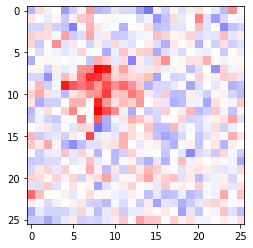

In [62]:
cell = 3
plt.imshow(weight[cell].sum(0), cmap='bwr', vmin = -np.abs(weight[cell].sum(0)).max(), vmax = np.abs(weight[cell].sum(0)).max())

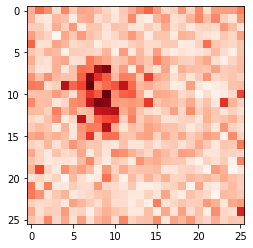

In [63]:
cell = 3
plt.imshow(np.abs(weight[cell]).sum(0), cmap='Reds')

In [189]:
device = torch.device('cuda:6')
cfg = get_custom_cfg('fc')
model_func = getattr(models, cfg.Model.name)
model_kwargs = dict(cfg.Model)
model = model_func(**model_kwargs).to(device)
#checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack_FC/epoch_095_loss_39.46_pearson_0.6502.pth'
#checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack_FC/epoch_095_loss_24.83_pearson_0.6775.pth'
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack_FC/epoch_095_loss_4.80_pearson_0.6503.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
test_data = DataLoader(TestDataset(cfg), batch_size=500)
test_pc, pred, targ = pearsonr_batch_eval(model, test_data, 6, device, cfg)

In [172]:
checkpoint['optimizer_state_dict']['param_groups']

[{'lr': 0.0004,
  'betas': (0.9, 0.999),
  'eps': 1e-08,
  'weight_decay': 0.001,
  'amsgrad': False,
  'params': [0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25]}]

In [190]:
w = model.ganglion[-1].w.data
positive = w - torch.min(w,1)[0][:,None]
normed = positive.permute(1,0) / positive.sum(-1)
prob = normed.permute(1,0).cpu().numpy()

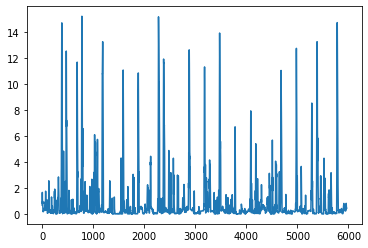

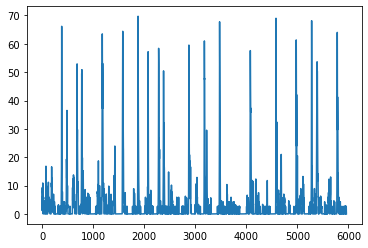

In [158]:
plt.plot(pred[:, 0])
plt.show()
plt.plot(targ[:, 0])
plt.show()

In [107]:
pred[1000, 0]

1.1162243

In [191]:
prob[1].max()

0.9311061

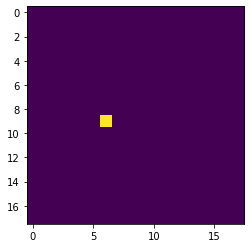

In [176]:
plt.imshow(prob[5].reshape(18, 18))

In [192]:
for i in range(6):
    idx = np.where(prob[i] == prob[i].max())[0][0]
    print(i, idx, (idx//18, idx%18))

0 224 (12, 8)
1 153 (8, 9)
2 81 (4, 9)
3 95 (5, 5)
4 165 (9, 3)
5 168 (9, 6)


### Phase 2

In [211]:
device = torch.device('cuda:6')
cfg = get_custom_cfg('fc')
model_func = getattr(models, cfg.Model.name)
model_kwargs = dict(cfg.Model)
model = model_func(**model_kwargs).to(device)
#checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack_FC_2/epoch_095_loss_-1.15_pearson_0.6910.pth'
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack_FC_2/epoch_095_loss_-0.78_pearson_0.6443.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
test_data = DataLoader(TestDataset(cfg), batch_size=500)
test_pc, pred, targ = pearsonr_batch_eval(model, test_data, 6, device, cfg)

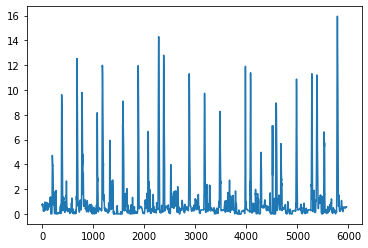

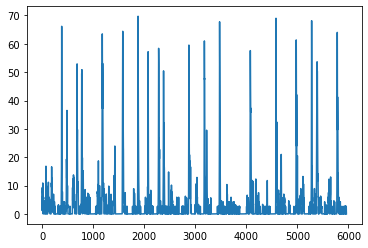

In [228]:
plt.plot(pred[:, 0])
plt.show()
plt.plot(targ[:, 0])
plt.show()

In [183]:
file_path = '/home/xhding/tem_stim/21-03-15/naturalscene.h5'
cells = [0,1,2,3,4,6]
t_list = [3,3,3,3,2,3]
recording = recording_stats(file_path, cells)
single_trial_bin = recording.single_trial_bin

In [217]:
noise_corr2(pred_single_trial_try)

array([[ 7.39760057e-01,  1.46515539e-02,  2.04711410e-03,
         2.15979431e-03, -3.47719196e-03,  1.03683587e-02],
       [ 1.46515539e-02,  7.97268036e-01,  6.48503080e-03,
         2.65168313e-03,  8.40097553e-03,  1.78147647e-02],
       [ 2.04711410e-03,  6.48503080e-03,  5.94417848e-01,
         5.38127507e-02,  1.54646006e-03, -9.70124305e-03],
       [ 2.15979431e-03,  2.65168313e-03,  5.38127507e-02,
         4.87571111e-01,  4.59600718e-04,  1.08539352e-02],
       [-3.47719196e-03,  8.40097553e-03,  1.54646006e-03,
         4.59600718e-04,  8.01529095e-01,  7.32258243e-03],
       [ 1.03683587e-02,  1.78147647e-02, -9.70124305e-03,
         1.08539352e-02,  7.32258243e-03,  7.42078940e-01]])

In [66]:
from torchdeepretina.utils import inspect
testset = TestDataset(cfg)
X = torch.from_numpy((testset.X.astype('float32') - testset.stats['mean']) / testset.stats['std'])
output = inspect(model, X.to(device), ['bipolar.2', 'amacrine.3'])

In [67]:
np.abs(X).mean(), np.abs(output['bipolar.2']).mean(), np.abs(output['amacrine.3']).mean()

(tensor(0.7589), 0.024389429, 0.018858405)

In [244]:
for seed in range(100):
    binomial_para = [2.17, 2.85, 1.91, 1.69, 1.0, 0.47]
    error_stats_post = []
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [0., 0, 0.15, 0], seed=seed, noise_locs=[3,4,5])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, seed=seed, thre=5.5)

    min_error = 10
    for i in range(300):
        pred_single_trial = pred_single_trial_multi[i]
        error = error_corr2(single_trial_bin, pred_single_trial)
        if error < min_error:
            min_error = error
    print(seed, min_error)

0 0.004522991469430313
1 0.0023964422389623928
2 0.0020516721140764324
3 0.0027169779425363456
4 0.0023716562889227488
5 0.002349779155763369
6 0.0025878451498318558
7 0.0025982660130787704
8 0.0023712939472043436
9 0.002260327534260462
10 0.005135137790625135
11 0.005633785085355527
12 0.00573001638000077
13 0.003488442948262055
14 0.0025059379777326203
15 0.003939075838862793
16 0.003944832256346197
17 0.0045796258818880786
18 0.004786012967090953
19 0.0031180818049271765
20 0.0020528299090162715
21 0.003187045548525665
22 0.00441015537047697
23 0.002134658831679872
24 0.004835491218824385
25 0.0023897735048405986
26 0.0013370891039288626
27 0.002940356857248674
28 0.007588316032682692
29 0.002868418852104386
30 0.002311764435744694
31 0.003113815513949615
32 0.002531315067991395
33 0.004467693163957029
34 0.004850239291728145
35 0.004743692110823816
36 0.002765150153465768
37 0.005219684432978054
38 0.0030579625299984384
39 0.0030821609892712513
40 0.00309344525509864
41 0.004173651

In [245]:
for seed in range(100):
    binomial_para = [2.17, 2.85, 1.91, 1.69, 1.0, 0.47]
    error_stats_post = []
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [0., 0, 0.2, 0], seed=seed, noise_locs=[3,4,5])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, seed=seed, thre=5.5)

    min_error = 10
    for i in range(300):
        pred_single_trial = pred_single_trial_multi[i]
        error = error_corr2(single_trial_bin, pred_single_trial)
        if error < min_error:
            min_error = error
    print(seed, min_error)

0 0.002956051231961876
1 0.0022413006377688164
2 0.002688638398602406
3 0.0021421142227283484
4 0.0016633901322146319
5 0.0025541186338796664
6 0.003050125069579694
7 0.0022295896957083834
8 0.0011758823320345776
9 0.0020903548441006817
10 0.004986355568878728
11 0.004840368198563508
12 0.004968337099090378
13 0.003723186034983303
14 0.002063574201412571
15 0.0019954177426046104
16 0.004566535862443949
17 0.006134163245416873
18 0.005106949936472859
19 0.004635888623642806
20 0.002023402482401883
21 0.005267242594262558
22 0.006549589346027134
23 0.0019106265518734871
24 0.007009982972520026
25 0.002102486784261707
26 0.004031393248700933
27 0.003750420536349764
28 0.005713362140557289
29 0.0038436763054543236
30 0.001995337485365824
31 0.003618458809461295
32 0.0030950755726002724
33 0.003333032292603923
34 0.002157270850841873
35 0.004929475395695625
36 0.0034118069362475516
37 0.006995062366666838
38 0.0027422403309477826
39 0.004448006342701054
40 0.003034247261243327
41 0.00479519

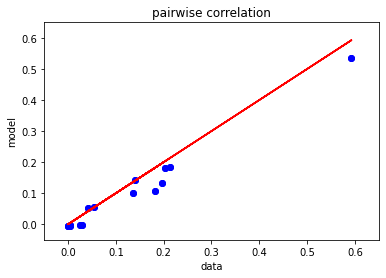

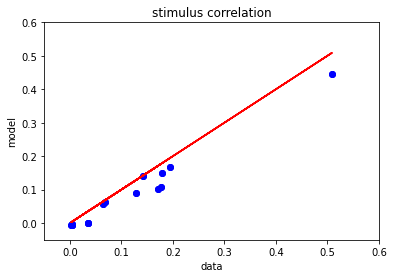

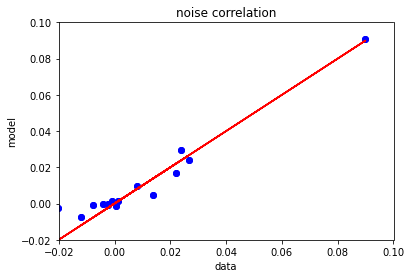

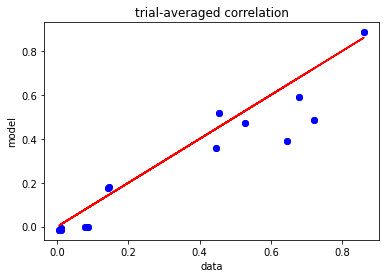

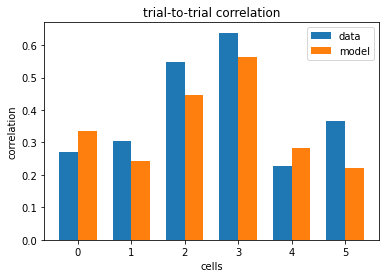

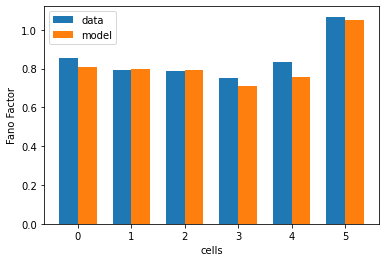

0.0011211203876315796


In [246]:
binomial_para = [2.17, 2.85, 1.91, 1.69, 1.0, 0.47]
error_stats_post = []
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [0., 0, 0.15, 0], seed=86, noise_locs=[3,4,5])
poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, seed=86, thre=5.5)

min_error = 10
for i in range(300):
    pred_single_trial = pred_single_trial_multi[i]
    error = error_corr2(single_trial_bin, pred_single_trial)
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
        
correlation_plot_2(single_trial_bin, pred_single_trial_try)
print(min_error)

In [251]:
for thre in np.arange(4.5, 6.5, 0.2):
    binomial_para = [2.17, 2.85, 1.91, 1.69, 1.0, 0.47]
    error_stats_post = []
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [0., 0, 0.15, 0], 55, noise_locs=[3,4,5])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, seed=55, thre=thre)

    min_error = 10
    for i in range(300):
        pred_single_trial = pred_single_trial_multi[i]
        error = error_corr2(single_trial_bin, pred_single_trial)
        if error < min_error:
            min_error = error
            pred_single_trial_try = pred_single_trial

    print(thre, variability_error(single_trial_bin, pred_single_trial_try))

4.5 1.4511127191960524
4.7 1.4213166033319682
4.9 1.39004483844564
5.1000000000000005 1.3584722471269013
5.300000000000001 1.3663157877327432
5.500000000000001 1.3064388138059524
5.700000000000001 1.2706644161744545
5.900000000000001 1.2390408392289531
6.100000000000001 1.330830706711854
6.300000000000002 1.18981250135591


In [252]:
for thre in np.arange(6.5, 7.5, 0.2):
    binomial_para = [2.17, 2.85, 1.91, 1.69, 1.0, 0.47]
    error_stats_post = []
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [0., 0, 0.15, 0], 55, noise_locs=[3,4,5])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, seed=55, thre=thre)

    min_error = 10
    for i in range(300):
        pred_single_trial = pred_single_trial_multi[i]
        error = error_corr2(single_trial_bin, pred_single_trial)
        if error < min_error:
            min_error = error
            pred_single_trial_try = pred_single_trial

    print(thre, variability_error(single_trial_bin, pred_single_trial_try))

6.5 1.249982799432828
6.7 1.2096823418832767
6.9 1.1338132400335754
7.1000000000000005 1.174011388811482
7.300000000000001 1.201907754043536


In [249]:
for thre in np.arange(3, 4.5, 0.2):
    binomial_para = [2.17, 2.85, 1.91, 1.69, 1.0, 0.47]
    error_stats_post = []
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [0., 0, 0.15, 0], 86, noise_locs=[3,4,5])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, seed=86, thre=thre)

    min_error = 10
    for i in range(300):
        pred_single_trial = pred_single_trial_multi[i]
        error = error_corr2(single_trial_bin, pred_single_trial)
        if error < min_error:
            min_error = error
            pred_single_trial_try = pred_single_trial

    print(thre, variability_error(single_trial_bin, pred_single_trial_try))

3.0 1.601858738278663
3.2 1.6780249557286562
3.4000000000000004 1.6258847028294754
3.6000000000000005 1.544863465597037
3.8000000000000007 1.5369228623610691
4.000000000000001 1.5406192077384808
4.200000000000001 1.539692476895623
4.400000000000001 1.550734520489299


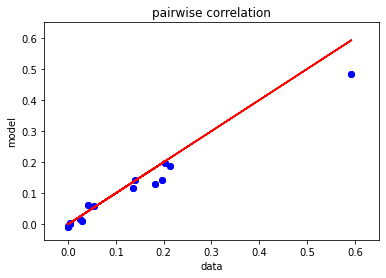

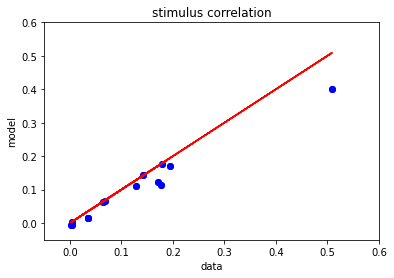

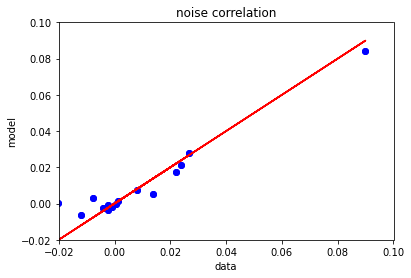

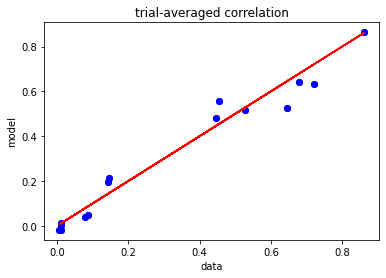

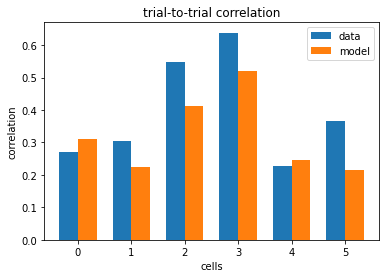

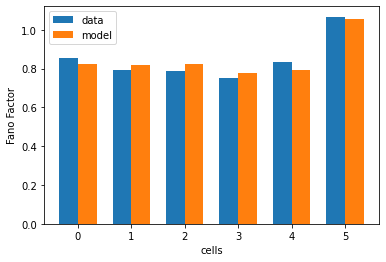

0.0014343937860831772


In [250]:
binomial_para = [2.17, 2.85, 1.91, 1.69, 1.0, 0.47]
error_stats_post = []
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [0., 0, 0.15, 0], seed=86, noise_locs=[3,4,5])
poly_paras = poly_para_fit(recording, pred_single_trial_pre, t_list)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=300, seed=86, thre=3.8)

min_error = 10
for i in range(300):
    pred_single_trial = pred_single_trial_multi[i]
    error = error_corr2(single_trial_bin, pred_single_trial)
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
        
correlation_plot_2(single_trial_bin, pred_single_trial_try)
print(min_error)